In [216]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [217]:
ground_folder = "../data/ground/ground_data.csv"
ground_path = Path(ground_folder)
df_ground = pd.read_csv(ground_path, encoding= 'unicode_escape')

df_ground['Timestamp'] = pd.to_datetime(df_ground['Time'], format="%Y/%m/%d %H:%M:%S").values.astype(float) // 10 ** 9
df_ground['Timestamp'] = df_ground['Timestamp'] - df_ground['Timestamp'][0]

df_ground

,Time,Voltage [V],Current [A],Power [W],Temperature [C],Timestamp
0,2020/07/21 10:06:59,4.068,-20.011,-81.397232,23.289,0.0
1,2020/07/21 10:07:00,4.057,-19.998,-81.134929,23.193,1.0
2,2020/07/21 10:07:01,4.055,-19.998,-81.085404,23.221,2.0
3,2020/07/21 10:07:02,4.053,-19.999,-81.050204,23.233,3.0
4,2020/07/21 10:07:03,4.051,-19.999,-81.014614,23.312,4.0
...,...,...,...,...,...,...
30599,2020/07/21 18:36:39,4.150,0.239,0.991035,23.496,30580.0
30600,2020/07/21 18:36:40,4.150,0.247,1.024197,23.427,30581.0
30601,2020/07/21 18:36:41,4.150,0.242,1.004299,23.467,30582.0
30602,2020/07/21 18:36:42,4.150,0.231,0.957864,23.442,30583.0


In [218]:
df_ground_dropped = df_ground.drop_duplicates(subset=['Timestamp'], keep='first')

In [197]:
output_folder = "../data/output/enrica_current_load/"
experiment_folder = "2023-04-27_11-46/dataset.csv"
experiment_path = Path(output_folder) / Path(experiment_folder)

df = pd.read_csv(experiment_path)

In [117]:
df

,Time,soc,soh,Voltage [V],Current [A],Power [W],Vocv,R0,R1,C,Temperature [C],Dissipated Heat [W]
0,-1.0,1.000000,1.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.00000,23.000000,0.000000
1,0.0,0.999722,NaN,4.051673,20.011,-81.078037,4.128000,0.00375,0.002905,15316.22569,22.996120,1.501801
2,1.0,0.999444,NaN,4.050209,19.998,-80.996085,4.127736,0.00375,0.002905,15316.22569,22.992245,1.499850
3,2.0,0.999167,NaN,4.048724,19.998,-80.966382,4.127472,0.00375,0.002905,15316.22569,22.988376,1.499850
4,3.0,0.998889,NaN,4.047262,19.999,-80.941187,4.127208,0.00375,0.002905,15316.22569,22.984514,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
30578,30577.0,1.000000,NaN,4.129638,-0.245,1.011761,4.128000,0.00375,0.002905,15316.22569,20.003915,0.000225
30579,30578.0,1.000000,NaN,4.129630,-0.243,1.003500,4.128000,0.00375,0.002905,15316.22569,20.003909,0.000221
30580,30579.0,1.000000,NaN,4.129615,-0.239,0.986978,4.128000,0.00375,0.002905,15316.22569,20.003903,0.000214
30581,30580.0,1.000000,NaN,4.129645,-0.247,1.020022,4.128000,0.00375,0.002905,15316.22569,20.003897,0.000229


## Estimation of R_term and C_term

In [182]:
from scipy.optimize import minimize, curve_fit

In [198]:
def compute_temp(params):
    r_term, c_term = params
    
    q = df['Dissipated Heat [W]'][1:]
    dt = 1
    temp_ = df['Temperature [C]']
    env_temp = 20
    
    term_1 = q * r_term * dt
    term_2 = temp_ * r_term * c_term
    term_3 = env_temp * dt
    esitmated_temp = (term_1 + term_2 + term_3) / (r_term * c_term + dt)
    
    return esitmated_temp

In [202]:
def objective(params):
    y = np.array(compute_temp(params))
    y_true = np.array(df_ground_dropped['Temperature [C]'][:-1])
    
    print(len(y), len(y_true))

    obj = 0.0
    for i in range(len(y)):
        obj = obj + ((y[i]-y_true[i]) / y_true[i])**2    
    return obj

In [203]:
# initial guesses
x0 = np.zeros(2)
x0[0] = 0.37 # a
x0[1] = 1700 # b

In [204]:
x0_bounds = (0, 20.0)
x1_bounds = (0, 10000.0)

bounds = (x0_bounds, x1_bounds)
solution = minimize(objective, x0, method='SLSQP', bounds=bounds)

if solution.success:
    fitted_params = solution.x
    print(fitted_params)
else:
    raise ValueError(solution.message)

# show final objective
cObjective = 'Final Objective: ' + str(objective(x))
print(cObjective)

30583 30583
30583 30583
30583 30583


ValueError: Inequality constraints incompatible

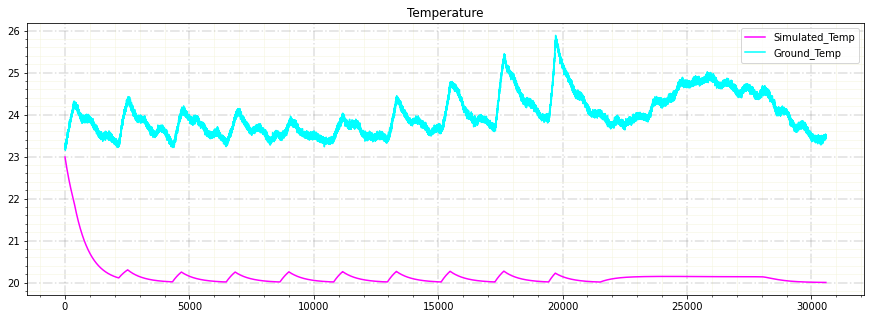

In [187]:
plt.figure(figsize=(15,5))
    
# Command for the grid
plt.grid(b=True, which='major', color='gray', alpha=0.25, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

# Plot iteratively all the variables
plt.plot(df['Time'], y, label='Simulated_Temp', color='magenta')
plt.plot(df_ground['Timestamp'], df_ground['Temperature [C]'], label='Ground_Temp', color='cyan')

plt.title("Temperature")
plt.legend()
plt.show()

In [250]:
x = list(df['Dissipated Heat [W]'])
t_ = list(df['Temperature [C]'])
y = list(df_ground_dropped['Temperature [C]'][1:])
y_err = [a-b for a, b in zip(df_ground_dropped['Temperature [C]'][1:], df['Temperature [C]'])]

In [251]:
len(x), len(t_), len(y), len(y_err)

(30583, 30583, 30583, 30583)

In [277]:
from scipy.optimize import curve_fit

def my_func(x, r_term, c_term):
    dt = 1
    env_temp = 20
    q, temp_ = x
        
    term_1 = q * r_term * dt
    term_2 = temp_ * r_term * c_term
    term_3 = env_temp * dt
    estimated_temp = (term_1 + term_2 + term_3) / (r_term * c_term + dt)        
    return estimated_temp

p0 = [0, 0]
popt, pcov = curve_fit(my_func, [x_, t_], y, p0, y_err, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("r_term = {0:10.3f} +- {1:10.3f}".format(popt[0], perr[0]))
print("c_term = {0:10.3f} +- {1:10.3f}".format(popt[1], perr[1]))

r_term =      4.605 +- 8682156.707
c_term =      0.899 +- 2026246.086


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

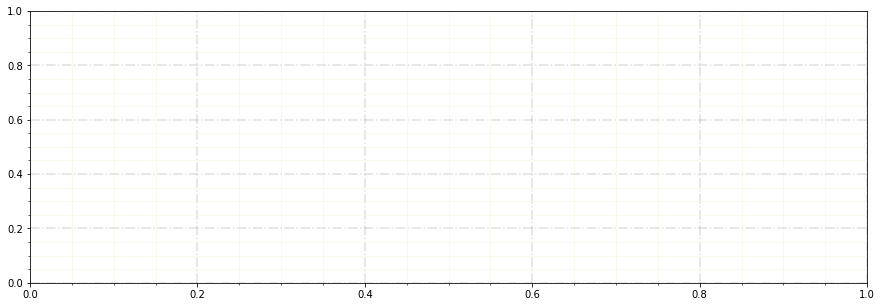

In [268]:
plt.figure(figsize=(15,5))
    
# Command for the grid
plt.grid(b=True, which='major', color='gray', alpha=0.25, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

# Plot iteratively all the variables
plt.plot(my_func([x, t_], popt[0], popt[1]), label='Simulated_Temp', color='magenta')
plt.plot(df_ground_dropped['Temperature [C]'], label='Ground_Temp', color='cyan')

plt.title("Temperature")
plt.legend()
plt.show()

In [279]:
from statsmodels.formula.api import ols

In [280]:
x1 = list(df['Dissipated Heat [W]'])
x2 = list(df['Temperature [C]'])
y = list(df_ground_dropped['Temperature [C]'])
data = {"x1": x1, "x2":x2, "y": y}

In [282]:
res = ols("y ~ (a*x1 + a*b*x2 + 20) / (a*b + 1)", data=data).fit()

PatsyError: numbers besides '0' and '1' are only allowed with **
    y ~ (a*x1 + a*b*x2 + 20) / (a*b + 1)
                         ^^

In [205]:
def my_func(r_term, c_term):
    q = df['Dissipated Heat [W]'][1]
    dt = 1
    temp_ = df['Temperature [C]'][0]
    env_temp = 20

    term_1 = q * r_term * dt
    term_2 = temp_ * r_term * c_term
    term_3 = env_temp * dt
    esitmated_temp = (term_1 + term_2 + term_3) / (r_term * c_term + dt)
    return esitmated_temp

In [214]:
import tensorflow as tf
from tqdm import tqdm

# Create needed objects
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
r_term = tf.Variable(0.37)
c_term = tf.Variable(1700.0)
cost = lambda: (my_func(r_term, c_term) - df_ground_dropped['Temperature [C]'][0]) ** 2

# Perform optimization
for _ in tqdm(range(100)):
     sgd.minimize(cost, var_list=[r_term, c_term])

# Extract results
print("R_term: ", r_term.numpy())
print("C_term: ", c_term.numpy())
print("Cost: ", cost().numpy())

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 211.85it/s]

R_term:  0.71678126
C_term:  1700.0
Cost:  0.08443496


In [293]:
def myfunc(X, a, b):
    x1, x2 = X
    return (a*x1 + a*b*x2 + 20) / (a*b + 1)

x1 = list(df['Dissipated Heat [W]'])
x2 = list(df['Temperature [C]'])
y = list(df_ground_dropped['Temperature [C]'][:-1])

p0 = 0.37, 1700.
popt, pcov = curve_fit(myfunc, (x1,x2), y, p0)
perr = np.sqrt(np.diag(pcov))
print("r_term = {0:10.3f} +- {1:10.3f}".format(popt[0], perr[0]))
print("c_term = {0:10.3f} +- {1:10.3f}".format(popt[1], perr[1]))

r_term = 4889494.926 +- 237581632321.809
c_term =      0.314 +-      0.019


In [ ]:

popt, pcov = curve_fit(my_func, [x_, t_], y, p0, y_err, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("r_term = {0:10.3f} +- {1:10.3f}".format(popt[0], perr[0]))
print("c_term = {0:10.3f} +- {1:10.3f}".format(popt[1], perr[1]))